In [1]:
import numpy as np

from matplotlib import pyplot as plt 
 
from wpg.wavefront import Wavefront
from wpg.beamline import Beamline

from wpg.source import sase_pulse
from wpg.optical_elements import Drift, Aperture, Lens
from wpg.wpg_uti_oe import propagation_parameters

from midsim.source import analytical_pulse_divergence, analytical_pulse_width

import scipy.constants

h = scipy.constants.physical_constants['Planck constant in eV s'][0]


In [2]:
from matplotlib.colors import LogNorm, Normalize

def plot_wfr(wfr, logscale=False, title = None):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    intensity = wfr.get_intensity().sum(-1)
    
    if logscale:
        norm = LogNorm(vmin=intensity[intensity > 0].min(), vmax=intensity.max())
    else:
        norm = Normalize(vmin=intensity.min(), vmax=intensity.max())
    
    try:
        extent =  [a*1e3 for a in [wfr.xMin, wfr.xMax, wfr.yMin, wfr.yMax]]
        
    except(TypeError):
        extent =  [a*1e3 for a in [wfr.qxMin, wfr.qxMax, wfr.qyMin, wfr.qyMax]]

    im = ax.imshow(intensity,
                   extent=extent,
                   cmap='afmhot',
                   norm=norm)
    
    ax.set_xlabel('x (mm)')
    ax.set_xlabel('y (mm)')
    
    if title:
        ax.set_title(title)
    fig.colorbar(im, ax=ax, orientation='vertical')


In [3]:
x = y = np.linspace(-500e-06, 500e-06, 2000)
t = np.linspace(-50e-15, 50e-15, 2)

theta_12 = 3.3e-03
theta_3 = 1.3e-03
L = 800e-03
theta_y = [0,2.5e-06]
photon_energy = 10e3

wavefronts = sase_pulse(x=x,
                        y=y,
                        t=t,
                        photon_energy=photon_energy,
                        pulse_energy=1e-03,
                        pulse_duration=15e-15,
                        bandwidth=1e-12,
                        sigma=analytical_pulse_width(photon_energy),
                        div=analytical_pulse_divergence(photon_energy),
                        x0=0.0,
                        y0=0.0,
                        t0=0.0,
                        theta_x=0.0,
                        theta_y=theta_y,
                        domain='freq',
                        polarization = 'horizontal')

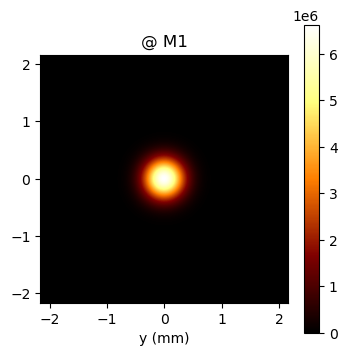

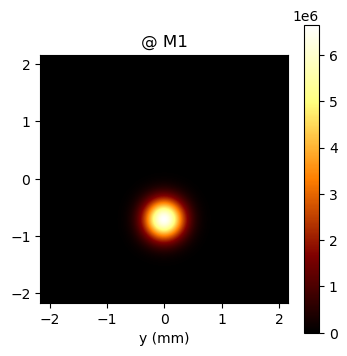

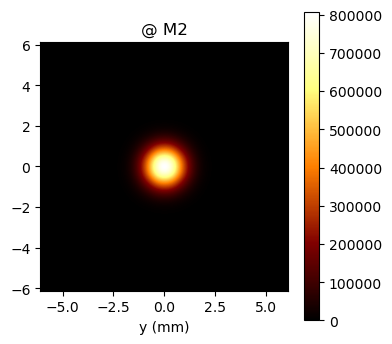

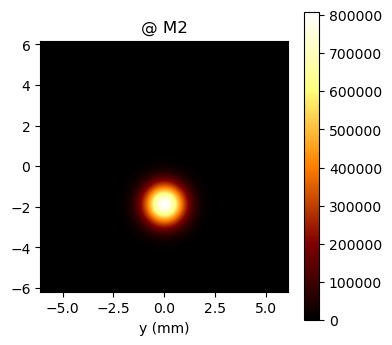

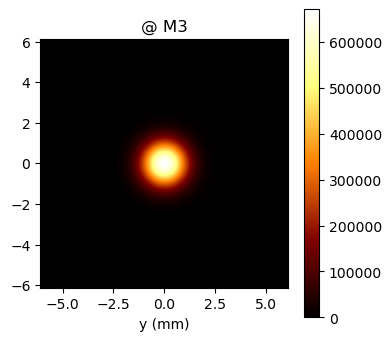

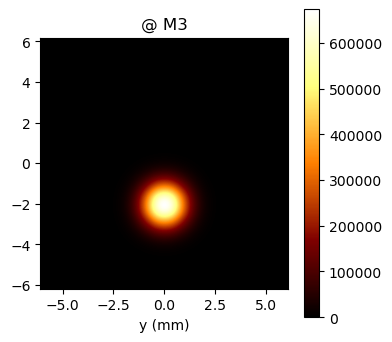

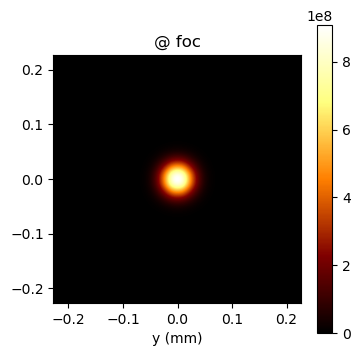

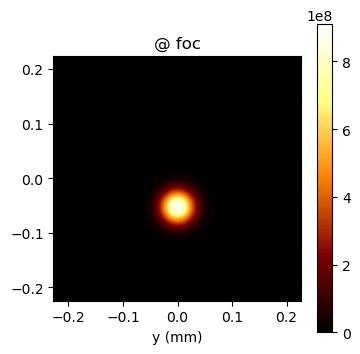

In [4]:
M1 = M2 = Aperture('r','a',Dx = L*theta_12, Dy = 10, x = 0, y = 0)
M3 = Aperture('r', 'a', Dx = L*theta_3, Dy = 10, x = L*theta_3, y = 0)
CRL1 = Lens(930, 930)


bl = Beamline()
bl.append(Drift(229), propagation_parameters(3.5,1,3.5,1,mode='fresnel'))
bl.append(CRL1, propagation_parameters(1,1,1,1,mode = 'fresnel'))
bl.append(Drift(71), propagation_parameters(1,1,1,1,mode='fraunhofer'))
bl.append(M1, propagation_parameters(1,1,1,1,mode = 'fresnel'))

for wfr in wavefronts:
    bl.propagate(wfr)
    plot_wfr(wfr, logscale = False, title = "@ M1")


bl = Beamline()
bl.append(Drift(11), propagation_parameters(1,1,1,1,mode='fresnel'))
bl.append(M2, propagation_parameters(1,1,1,1,mode = 'fresnel'))
bl.append(Drift(600), propagation_parameters(2,1,2,1,mode = 'quadratic'))

for wfr in wavefronts:
    bl.propagate(wfr)
    plot_wfr(wfr, logscale = False, title = "@ M2")

bl = Beamline()
bl.append(Drift(90), propagation_parameters(1,1,1,1,mode='fresnel'))
#bl.append(M3, propagation_parameters(1,1,1,1,mode = 'fresnel'))
for wfr in wavefronts:
    bl.propagate(wfr)
    plot_wfr(wfr, logscale = False, title = "@ M3")

CRL2 = Lens(28,28)


bl = Beamline()
bl.append(CRL2, propagation_parameters(1,1,1,1,mode = 'fresnel'))
bl.append(Drift(28), propagation_parameters(2.5,2,2.5,2,mode='converge'))

for wfr in wavefronts:
    bl.propagate(wfr)
    plot_wfr(wfr, logscale = False, title = '@ foc')



horizontal shift:  -6.800378964588662e-07
horizontal shift:  5.28863375268389e-05


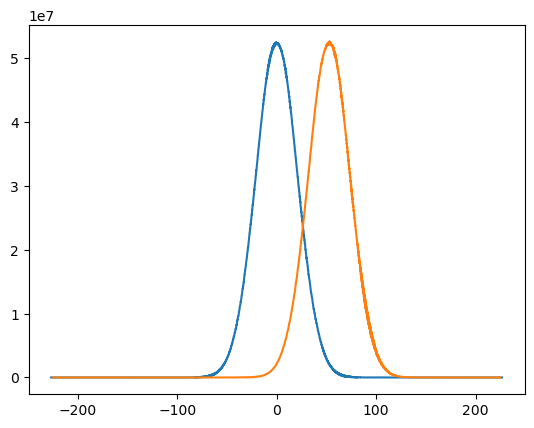

In [5]:
for wfr in wavefronts:
    plt.plot(wfr.get_axis('y')*1e6,wfr.get_profile('y', method = 'mean'))
    print("horizontal shift: ", wfr.get_axis('y')[np.argmax(wfr.get_profile('y'))])